# Variational Autoencoders

We'll use the HAM10000 dermatoscopic dataset again. This time we will use 1000 images, scaled down to 32x32 pixels. We'll ignore the labels, since we won't need them for an autoencoder.

In [136]:
!gdown 1Ls0Gi0vroFKqIEDGGyS5JDFsvTcsxWrR

Downloading...
From: https://drive.google.com/uc?id=1Ls0Gi0vroFKqIEDGGyS5JDFsvTcsxWrR
To: /content/HAM32x32.zip
100% 2.54M/2.54M [00:00<00:00, 17.2MB/s]


In [137]:
import zipfile
zip_ref = zipfile.ZipFile('HAM32x32.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

In [138]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
import matplotlib.pyplot as plt
seed(0)
from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
disable_eager_execution()

batch_size = 16
img_size = 32
img_shape = (img_size, img_size, 3)
latent_dim = 16

train_dir = 'HAM32x32'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels=None, # no labels for autoencoder!
    image_size=(img_size,img_size),
    batch_size=batch_size,
)


Found 1000 files.


Normalize the color values so each channel is between 0 and 1 (instead of 0-255).

In [139]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x: (normalization_layer(x)))

First we'll define the encoder. This will look similar to our previous CNNs, except we'll use "strided" convolutions to downsample instead of max pooling.

**1.-2. Use [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) to downsample the image twice, by 2x each time, in between the other convolutional layers. Use a filter size of 3 for both; use 32 filters for the first and 64 filters for the second. Use 'same' padding and 'relu' activation.**
  - Hint: note that we are not using a Sequential model, but instead passing each layer into the next directly. By convention, we will redefine `x` at each intermediate layer after passing the current `x` into it.
  - Hint: Choose the appropriate `strides` to downsample by 2x.

In [140]:
import tf_keras as keras
from tf_keras import layers
from tf_keras import backend as K
from tf_keras.models import Model
import numpy as np

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)

# YOUR CODE HERE (1)
x = layers.Conv2D(32, 3,
                  padding='same', strides=(2,2), activation='relu')(x)

x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)

# YOUR CODE HERE (2)
x = layers.Conv2D(64, 3,
                  padding='same', strides=(2,2), activation='relu')(x)

x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

Unlike other CNNs, the flattened features will now be routed to two different layers, representing mu and sigma.

In [141]:
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Now we need to randomly sample from those distributions to get z. There is no premade Keras layer for that, so we will have to wrap a function in a "Lambda" layer, which lets you execute arbitrary code within a layer.

In [142]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

Next is the decoder, will largely mirror the encoder to go from a latent vector back up to the same size and channels (3 for RGB) as the original image.

**3.-4. Use [Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) to upsample the image twice, by 2x each time, in between the other convolutional layers. Use a filter size of 3 for both; use 64 filters for the first and 32 filters for the second. Use 'same' padding and 'relu' activation.**

In [143]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2D(64, 3,
                  padding='same',
                  activation='relu')(x)

# YOUR CODE HERE (3)
x = layers.Conv2DTranspose(64, 3, strides=(2,2),
                  padding='same',
                  activation='relu')(x)

x = layers.Conv2D(64, 3,
                  padding='same',
                  activation='relu')(x)

# YOUR CODE HERE (4)
x = layers.Conv2DTranspose(32, 3, strides=(2,2),
                  padding='same',
                  activation='relu')(x)

**5. Finish the decoder with a [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layer with 3 filters to produce red, green, and blue, each 3x3 and with 'same' padding.**
- Hint: Choose the appropriate activation to recreate the original image (remember the input channels were scaled to 0-1).

In [144]:
# YOUR CODE HERE (5)
x = layers.Conv2D(3, (3,3),
                  padding='same',
                  activation='sigmoid')(x)

Now we can create a Keras Model object for the decoder, by specifying the input and output layers.

In [145]:
decoder = Model(decoder_input, x)
decoder.summary()
z_decoded = decoder(z)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 16)]              0         
                                                                 
 dense_44 (Dense)            (None, 4096)              69632     
                                                                 
 reshape_11 (Reshape)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_91 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 conv2d_transpose_22 (Conv2  (None, 16, 16, 64)        36928     
 DTranspose)                                                     
                                                                 
 conv2d_92 (Conv2D)          (None, 16, 16, 64)        36928     
                                                          

Now we will make a custom layer for the loss and complete the VAE model. Note that a warning about missing loss is expected, since we are computing it ourselves.

In [146]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -1e-3 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img, z_decoded])

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [147]:
vae.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_86 (Conv2D)          (None, 32, 32, 32)           896       ['input_22[0][0]']            
                                                                                                  
 conv2d_87 (Conv2D)          (None, 16, 16, 32)           9248      ['conv2d_86[0][0]']           
                                                                                                  
 conv2d_88 (Conv2D)          (None, 16, 16, 64)           18496     ['conv2d_87[0][0]']           
                                                                                           

**6. Fit the `vae` model on the `train_ds` dataset for at least 100 epochs.**
  - Hint: Since this is an autoencoder, there are no labels! Remember, we are trying to get the input back as output, and the loss is the difference (plus the distributional difference loss).

(this will take a few minutes)

In [148]:
# YOUR CODE HERE (6)
vae.fit(train_ds, epochs=100)

Train on 63 steps
Epoch 1/100
63/63 [==============================] - 2s 10ms/step - batch: 31.0000 - size: 1.0000 - loss: 0.6695
Epoch 2/100
63/63 [==============================] - 1s 11ms/step - batch: 31.0000 - size: 1.0000 - loss: 0.6080
Epoch 3/100
63/63 [==============================] - 0s 8ms/step - batch: 31.0000 - size: 1.0000 - loss: 0.6245
Epoch 4/100
63/63 [==============================] - 0s 7ms/step - batch: 31.0000 - size: 1.0000 - loss: 0.6010
Epoch 5/100
63/63 [==============================] - 0s 7ms/step - batch: 31.0000 - size: 1.0000 - loss: 0.5915
Epoch 6/100
63/63 [==============================] - 0s 7ms/step - batch: 31.0000 - size: 1.0000 - loss: 0.5797
Epoch 7/100
63/63 [==============================] - 0s 7ms/step - batch: 31.0000 - size: 1.0000 - loss: 0.5749
Epoch 8/100
63/63 [==============================] - 0s 7ms/step - batch: 31.0000 - size: 1.0000 - loss: 0.5714
Epoch 9/100
63/63 [==============================] - 0s 7ms/step - batch: 31.0000 - 

Let's see what the VAE learned. We'll look at each feature in the latent vector (z) by generating images for ranges of each feature, while holding the other features at 0.

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training_v1.py:2354: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


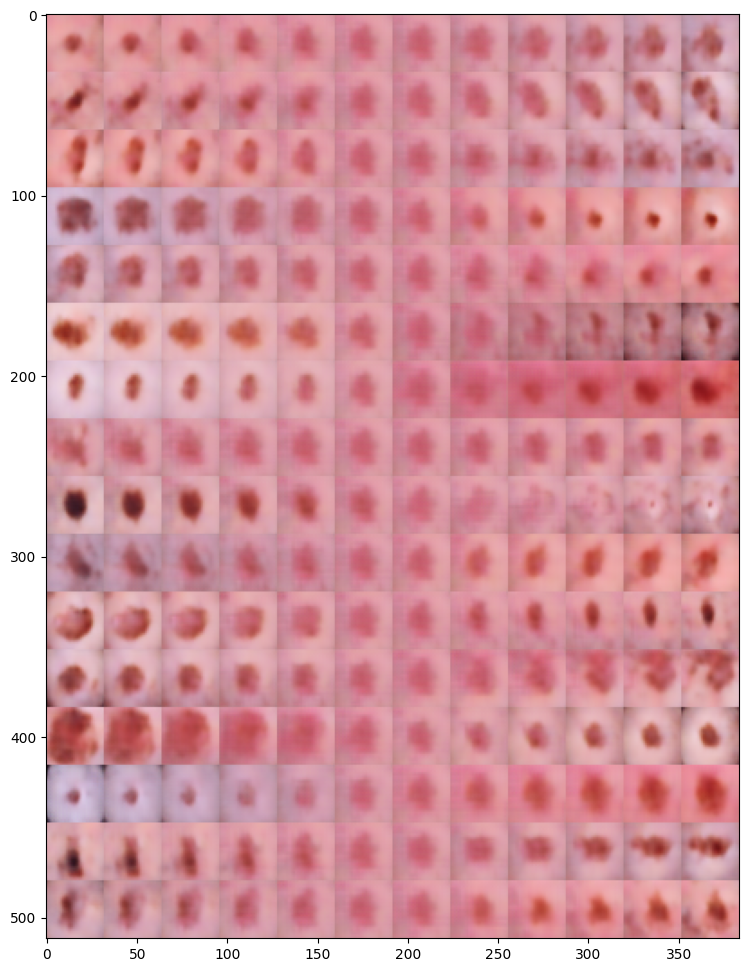

In [149]:
from scipy.stats import norm

n = 12
figure = np.zeros((img_size * latent_dim, img_size * n, 3))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))*1.5

for d in range(latent_dim):
    for i, xi in enumerate(grid_x):

        z_sample = np.zeros((latent_dim))
        z_sample[d] = xi

        # repeat for batching
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dim)

        x_decoded = decoder.predict(z_sample)

        img = x_decoded[0].reshape(img_size, img_size, 3)
        figure[d * img_size : (d + 1) * img_size,
               i * img_size : (i + 1) * img_size] = img
plt.figure(figsize=(9, 12))
plt.imshow(figure)
plt.show()

Each of the rows in the figure above shows a representative sampling of a single latent feature (feature `0` on top), with its extreme values at the left and right.

**7. Choose 2 features from the plot above to vary together. Store the feature indices in `dim_x` and `dim_y`.**
  - Hint: The rows in the plot above correspond to feature `0` at the top, and feature `latent_dim - 1` at the bottom.


In [150]:
# YOUR CODE HERE (7)
dim_x = 7
dim_y = 11

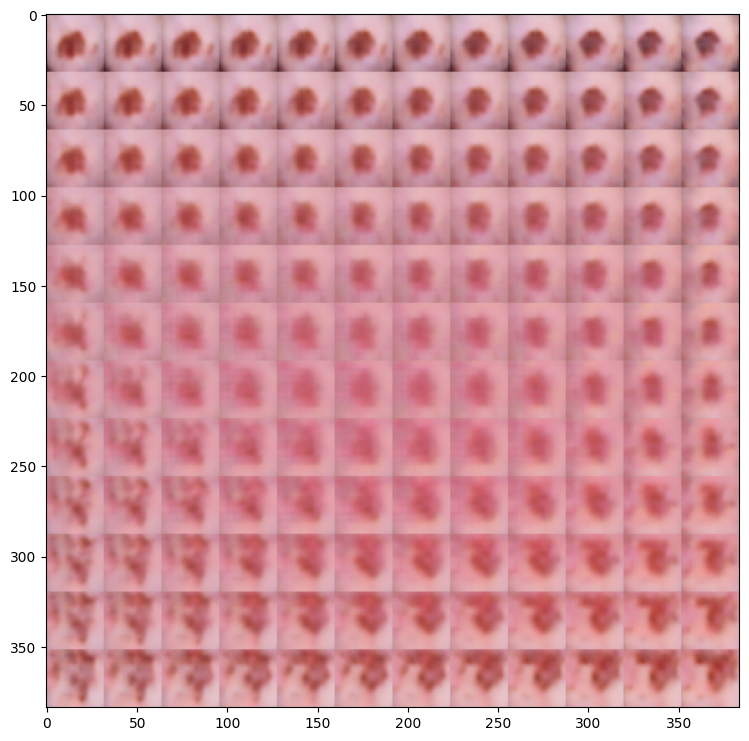

In [151]:
figure = np.zeros((img_size * n, img_size * n, 3))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))*1.5
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))*1.5

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.zeros((latent_dim))
        z_sample[dim_x] = xi
        z_sample[dim_y] = yi
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dim)
        x_decoded = decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, 3)
        figure[j * img_size : (j + 1) * img_size,
               i * img_size : (i + 1) * img_size] = img
plt.figure(figsize=(9, 9))
plt.imshow(figure)
plt.show()

Now the feature are varying together, with the extremes of both features at the corners. Do the features seem to combine?